In [59]:
import pandas as pd
import talib
from talib.abstract import *
import matplotlib.pyplot as plt

In [7]:
#installation worked only after installing the dependancy packages using (brew install ta-lib)
!pip install TA-Lib


  Using cached TA_Lib-0.4.32-cp311-cp311-macosx_14_0_arm64.whl


In [14]:
pwd

'/Users/abhisheksuga/Documents/Edu/thesis/gold/src'

In [20]:
df =  pd.read_csv("../data/gold.csv",header=0, index_col=0, parse_dates=True)

In [10]:
df.head()

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2000-01-04,289.5,289.5,280.0,283.7,21621,USD
2000-01-05,283.7,285.0,281.0,282.1,25448,USD
2000-01-06,281.6,282.8,280.2,282.4,19055,USD
2000-01-07,282.5,284.5,282.0,282.9,11266,USD
2000-01-10,282.4,283.9,281.8,282.7,30603,USD


In [11]:
len(df)

5703

In [12]:
df.isna().sum()

Open        0
High        0
Low         0
Close       0
Volume      0
Currency    0
dtype: int64

In [13]:
df = df[df.Open !=0]
df = df[df.High !=0]
df = df[df.Low !=0]
df = df[df.Close !=0]

In [14]:
def Add_Lag(data,col,lag_list):
    
    position = data.columns.tolist().index(col)
    
    for lag in lag_list:
    
        col_val = data[col].shift(lag)

        col_name = col+'_lag:'+'{length}'.format(length=lag)

        data.insert(loc=position, column=col_name, value=col_val)
        

    return data

In [22]:
def Indicator(Data):

    data = pd.DataFrame()
    data['Open'] = Data['Open']
    data['High'] = Data['High']
    data['Low'] = Data['Low']
    data['Close'] = Data['Close']
    data['Volume'] = Data['Volume']


    Orginal_columns_names = ['Open', 'High', 'Low', 'Close', 'Volume']
    
    #we apply indicators on one lage data
    Open = data['Open'].shift(1)
    High = data['High'].shift(1)
    Low = data['Low'].shift(1)
    Close = data['Close'].shift(1)
    Volume = data['Volume'].shift(1)

    Orginal_columns_values = {'open':Open,'high':High,'low':Low,'close':Close,'volume':Volume}
    #Gathering all functions in the Talib library
    Talib = talib.get_function_groups()
    Groups = list(Talib.keys())
    Indicators = []
    for group in Groups:
        for g in Talib[group]:
            Indicators.append(g)
    #As the following two functions are not returning an array with length of our data.shapep[0], we remove it
    Indicators.remove('MAVP')
    Indicators.remove('OBV')

    for indicator in Indicators:
        indicator = eval(indicator)
        
        #Here we have two types of functions(indicators,...):
        #The ones need just one column and the others which need more
        if len(indicator.output_names)==1:

            if list(indicator.get_input_names().values()) == ['close']:

                for col in Orginal_columns_names:

                    lagged_col = data[col].shift(1)

                    new_col = indicator(lagged_col)

                    name = indicator.info['name']

                    col_name = col+'_'+'{Name}'.format(Name=name)

                    data[col_name] = new_col

            
            else: #Functions need more than one features, e.g. [High, Low, Close, Open]

                name = indicator.info['name']

                inputs = list(indicator.get_input_names().values())

                if len(inputs)==2:

                    new_col = indicator(Orginal_columns_values[inputs[0]],Orginal_columns_values[inputs[1]])

                    data[name] = new_col
                    
                elif len(inputs)==3:

                    new_col = indicator(Orginal_columns_values[inputs[0]],Orginal_columns_values[inputs[1]],Orginal_columns_values[inputs[2]])
                    
                    data[name] = new_col

                elif len(inputs)==4:
                    
                    new_col = indicator(Orginal_columns_values[inputs[0]],Orginal_columns_values[inputs[1]],Orginal_columns_values[inputs[2]],Orginal_columns_values[inputs[3]])
                    
                    data[name] = new_col
    
    remove_col = []
    for col in data.columns:
        if float('-inf') in data[col].values: #Remove columns that have very large values
            remove_col.append(col)
        if data.tail(data.shape[0]-100)[col].isnull().values.any()==True: #remove columns that have nan values which are not cause of lags
            remove_col.append(col)
            
    remove_col = remove_col+Orginal_columns_names
    data.drop(remove_col,axis=1,inplace=True)

    return data



In [23]:
new_data = Indicator(df)

/var/folders/bz/q_7jbqjx7hj_vffhkj3cyl_m0000gn/T/ipykernel_11060/2626521298.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col_name] = new_col
/var/folders/bz/q_7jbqjx7hj_vffhkj3cyl_m0000gn/T/ipykernel_11060/2626521298.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col_name] = new_col
/var/folders/bz/q_7jbqjx7hj_vffhkj3cyl_m0000gn/T/ipykernel_11060/2626521298.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

In [31]:
len(new_data)

5703

In [26]:
def add_diff(data,col): #A simple type of features which calculate just the difference between sequential values in each columns

    position = data.columns.tolist().index(col)

    diff = [0,0]

    for i in range(1,data.shape[0]-1):

        difference = data[col][i] -  data[col][i-1]

        diff.append(difference)
    
    col_name = col+'_difference'

    data.insert(loc=position, column=col_name, value=diff)

    return data

In [36]:
df2 =  pd.read_csv("../data/data (1).csv")


In [37]:
df2.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,SP_open,SP_high,SP_low,...,GDX_Low,GDX_Close,GDX_Adj Close,GDX_Volume,USO_Open,USO_High,USO_Low,USO_Close,USO_Adj Close,USO_Volume
1713,2018-12-24,119.570000,120.139999,119.570000,120.019997,120.019997,9736400,239.039993,240.839996,234.270004,...,20.650000,21.090000,21.090000,60507000,9.49,9.52,9.28,9.29,9.29,21598200
1714,2018-12-26,120.620003,121.000000,119.570000,119.660004,119.660004,14293500,235.970001,246.179993,233.759995,...,20.530001,20.620001,20.620001,76365200,9.25,9.92,9.23,9.90,9.90,40978800
1715,2018-12-27,120.570000,120.900002,120.139999,120.570000,120.570000,11874400,242.570007,248.289993,238.960007,...,20.700001,20.969999,20.969999,52393000,9.59,9.65,9.37,9.62,9.62,36578700
1716,2018-12-28,120.800003,121.080002,120.720001,121.059998,121.059998,6864700,249.580002,251.399994,246.449997,...,20.570000,20.600000,20.600000,49835000,9.54,9.65,9.38,9.53,9.53,22803400
1717,2018-12-31,120.980003,121.260002,120.830002,121.250000,121.250000,8449400,249.559998,250.190002,247.470001,...,20.559999,21.090000,21.090000,53866600,9.63,9.71,9.44,9.66,9.66,28417400


In [66]:
df2.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'SP_open', 'SP_high', 'SP_low', 'SP_close', 'SP_Ajclose', 'SP_volume',
       'DJ_open', 'DJ_high', 'DJ_low', 'DJ_close', 'DJ_Ajclose', 'DJ_volume',
       'EG_open', 'EG_high', 'EG_low', 'EG_close', 'EG_Ajclose', 'EG_volume',
       'EU_Price', 'EU_open', 'EU_high', 'EU_low', 'EU_Trend', 'OF_Price',
       'OF_Open', 'OF_High', 'OF_Low', 'OF_Volume', 'OF_Trend', 'OS_Price',
       'OS_Open', 'OS_High', 'OS_Low', 'OS_Trend', 'SF_Price', 'SF_Open',
       'SF_High', 'SF_Low', 'SF_Volume', 'SF_Trend', 'USB_Price', 'USB_Open',
       'USB_High', 'USB_Low', 'USB_Trend', 'PLT_Price', 'PLT_Open', 'PLT_High',
       'PLT_Low', 'PLT_Trend', 'PLD_Price', 'PLD_Open', 'PLD_High', 'PLD_Low',
       'PLD_Trend', 'RHO_PRICE', 'USDI_Price', 'USDI_Open', 'USDI_High',
       'USDI_Low', 'USDI_Volume', 'USDI_Trend', 'GDX_Open', 'GDX_High',
       'GDX_Low', 'GDX_Close', 'GDX_Adj Close', 'GDX_Volume', 'USO_Open',
       'USO_Hig

In [67]:
df2['Date'] = pd.to_datetime(df2['Date'])

In [68]:
#checking corelation of adj close price with all the other features
corr = df2.corr().abs()['Adj Close'].sort_values(ascending = False)

In [69]:
corr

Close         1.000000
Adj Close     1.000000
High          0.999535
Low           0.999532
Open          0.998976
                ...   
PLD_Trend     0.026536
USB_Trend     0.025933
EU_Trend      0.019913
USDI_Trend    0.016641
PLT_Trend     0.011355
Name: Adj Close, Length: 81, dtype: float64

In [51]:
to_drop = corr[corr < 0.35]  #features to drop due to lesser correlation
to_drop

Volume         0.246778
SP_volume      0.241949
OF_Volume      0.225436
PLD_High       0.217490
PLD_Open       0.216426
PLD_Low        0.214919
PLD_Price      0.213179
USDI_Volume    0.205954
DJ_volume      0.155526
EG_volume      0.126586
RHO_PRICE      0.095782
OS_Trend       0.059510
OF_Trend       0.048205
SF_Trend       0.028100
PLD_Trend      0.026536
USB_Trend      0.025933
EU_Trend       0.019913
USDI_Trend     0.016641
PLT_Trend      0.011355
Name: Adj Close, dtype: float64

In [70]:
features_to_drop = list(to_drop.index)

In [71]:
data_new = df2.drop(features_to_drop, axis = 1)

In [72]:
data_new.head()

,Date,Open,High,Low,Close,Adj Close,SP_open,SP_high,SP_low,SP_close,...,GDX_Low,GDX_Close,GDX_Adj Close,GDX_Volume,USO_Open,USO_High,USO_Low,USO_Close,USO_Adj Close,USO_Volume
0,2011-12-15,154.740005,154.949997,151.710007,152.330002,152.330002,123.029999,123.199997,121.989998,122.180000,...,51.570000,51.680000,48.973877,20605600,36.900002,36.939999,36.049999,36.130001,36.130001,12616700
1,2011-12-16,154.309998,155.369995,153.899994,155.229996,155.229996,122.230003,122.949997,121.300003,121.589996,...,52.040001,52.680000,49.921513,16285400,36.180000,36.500000,35.730000,36.270000,36.270000,12578800
2,2011-12-19,155.479996,155.860001,154.360001,154.869995,154.869995,122.059998,122.320000,120.029999,120.290001,...,51.029999,51.169998,48.490578,15120200,36.389999,36.450001,35.930000,36.200001,36.200001,7418200
3,2011-12-20,156.820007,157.429993,156.580002,156.979996,156.979996,122.180000,124.139999,120.370003,123.930000,...,52.369999,52.990002,50.215282,11644900,37.299999,37.610001,37.220001,37.560001,37.560001,10041600
4,2011-12-21,156.979996,157.529999,156.130005,157.160004,157.160004,123.930000,124.360001,122.750000,124.169998,...,52.419998,52.959999,50.186852,8724300,37.669998,38.240002,37.520000,38.110001,38.110001,10728000


In [73]:
data_new.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'SP_open',
       'SP_high', 'SP_low', 'SP_close', 'SP_Ajclose', 'DJ_open', 'DJ_high',
       'DJ_low', 'DJ_close', 'DJ_Ajclose', 'EG_open', 'EG_high', 'EG_low',
       'EG_close', 'EG_Ajclose', 'EU_Price', 'EU_open', 'EU_high', 'EU_low',
       'OF_Price', 'OF_Open', 'OF_High', 'OF_Low', 'OS_Price', 'OS_Open',
       'OS_High', 'OS_Low', 'SF_Price', 'SF_Open', 'SF_High', 'SF_Low',
       'SF_Volume', 'USB_Price', 'USB_Open', 'USB_High', 'USB_Low',
       'PLT_Price', 'PLT_Open', 'PLT_High', 'PLT_Low', 'USDI_Price',
       'USDI_Open', 'USDI_High', 'USDI_Low', 'GDX_Open', 'GDX_High', 'GDX_Low',
       'GDX_Close', 'GDX_Adj Close', 'GDX_Volume', 'USO_Open', 'USO_High',
       'USO_Low', 'USO_Close', 'USO_Adj Close', 'USO_Volume'],
      dtype='object')

In [74]:
data_new = data_new.set_index("Date")

In [55]:
data_new.head()

,Open,High,Low,Close,Adj Close,SP_open,SP_high,SP_low,SP_close,SP_Ajclose,...,GDX_Low,GDX_Close,GDX_Adj Close,GDX_Volume,USO_Open,USO_High,USO_Low,USO_Close,USO_Adj Close,USO_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2011-12-15,154.740005,154.949997,151.710007,152.330002,152.330002,123.029999,123.199997,121.989998,122.180000,105.441238,...,51.570000,51.680000,48.973877,20605600,36.900002,36.939999,36.049999,36.130001,36.130001,12616700
2011-12-16,154.309998,155.369995,153.899994,155.229996,155.229996,122.230003,122.949997,121.300003,121.589996,105.597549,...,52.040001,52.680000,49.921513,16285400,36.180000,36.500000,35.730000,36.270000,36.270000,12578800
2011-12-19,155.479996,155.860001,154.360001,154.869995,154.869995,122.059998,122.320000,120.029999,120.290001,104.468536,...,51.029999,51.169998,48.490578,15120200,36.389999,36.450001,35.930000,36.200001,36.200001,7418200
2011-12-20,156.820007,157.429993,156.580002,156.979996,156.979996,122.180000,124.139999,120.370003,123.930000,107.629784,...,52.369999,52.990002,50.215282,11644900,37.299999,37.610001,37.220001,37.560001,37.560001,10041600
2011-12-21,156.979996,157.529999,156.130005,157.160004,157.160004,123.930000,124.360001,122.750000,124.169998,107.838242,...,52.419998,52.959999,50.186852,8724300,37.669998,38.240002,37.520000,38.110001,38.110001,10728000


In [75]:
titles = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'SP_open', 'SP_high', 'SP_low', 'SP_close',
          'SP_Ajclose','SP_volume','DJ_open', 'DJ_high' ]
feature_keys = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'SP_open', 'SP_high', 'SP_low', 'SP_close',
                'SP_Ajclose', 'SP_volume','DJ_open', 'DJ_high']

colors = [ "blue","orange","green","red","purple","brown","pink","gray","olive", "cyan"]

date_time_key = "Date"

In [76]:
def visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()

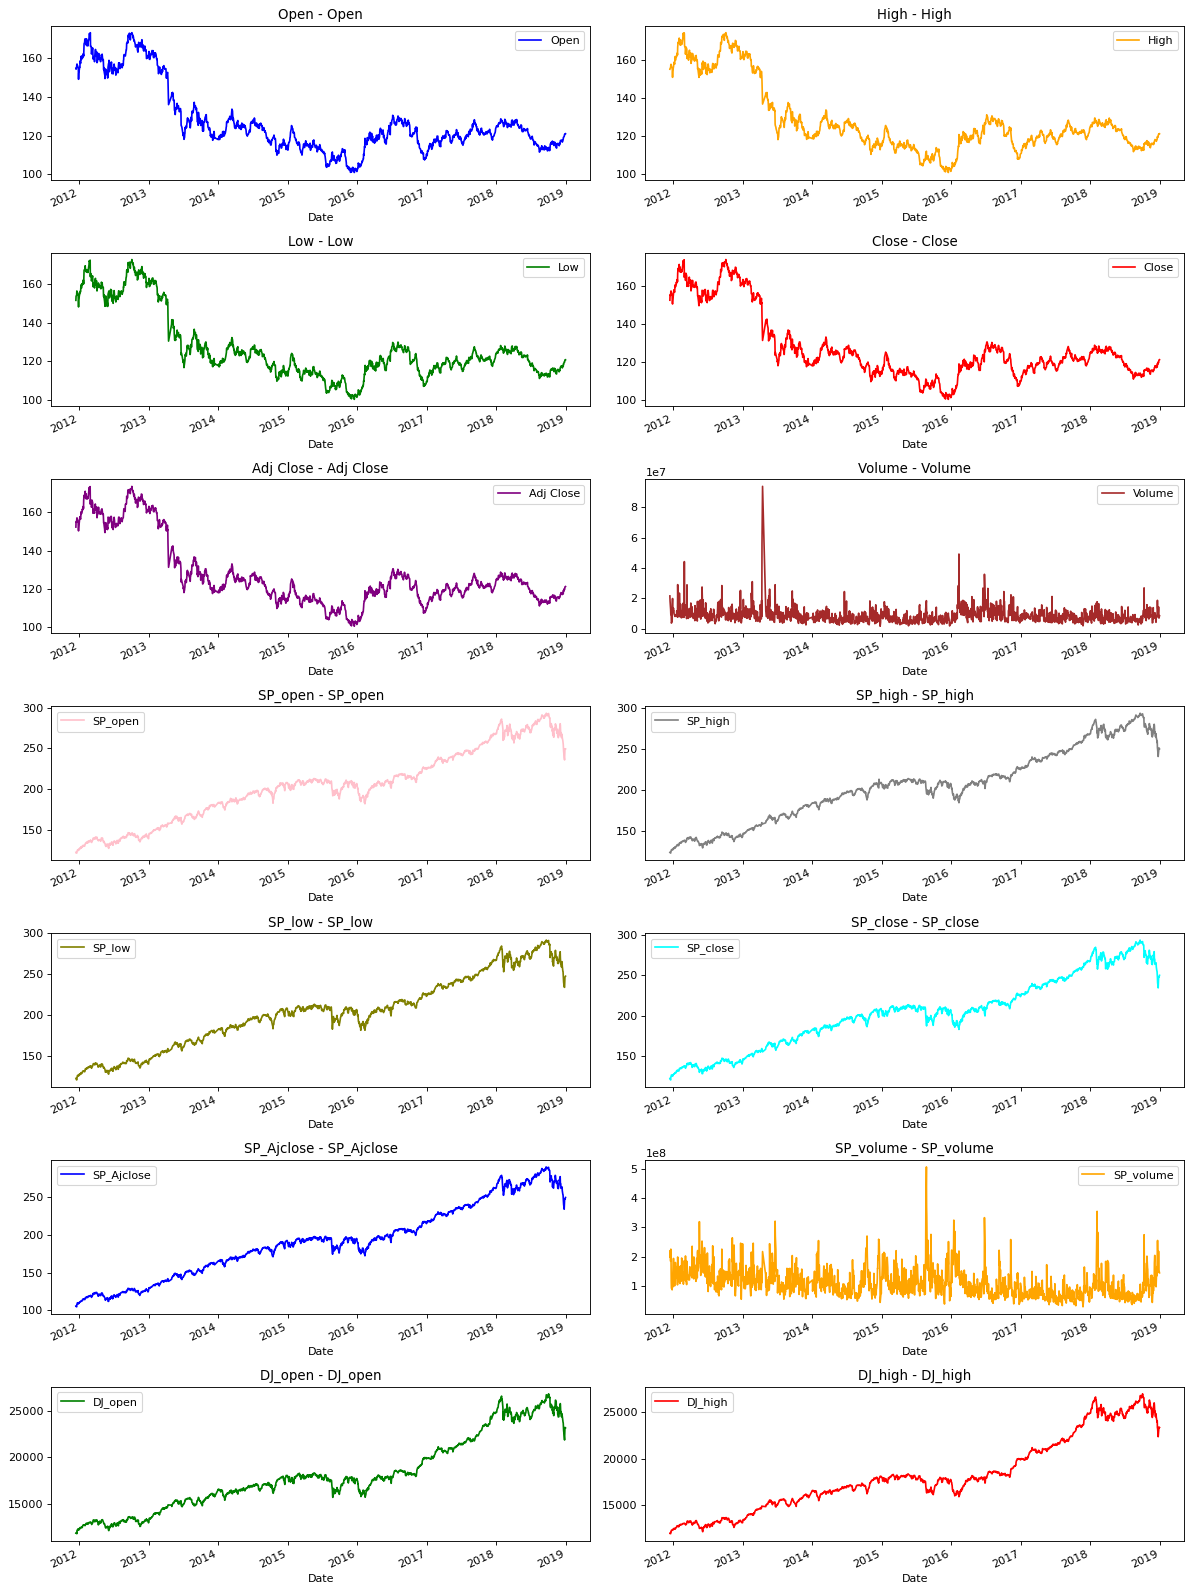

In [80]:
visualization(df2)

In [ ]:
#testing hourly based data from yahoo finanace
# import yfinance as yf
# from datetime import datetime

# gold = yf.download(tickers="GC=F", period="16y", interval="1d")

# start = datetime(2021, 10, 18, 9, 30, 0)
# end = datetime(2021, 10, 18, 10, 30, 0)

# filtered = gold[start: end]

## Expermentation 

In [112]:
#dataset of gold fetched from different sources  for different frequencies

gold_data_1h = pd.read_csv("/Users/abhisheksuga/Documents/Edu/thesis/gold/data/Gold_1h.csv")
gold_data_5m = pd.read_csv("/Users/abhisheksuga/Documents/Edu/thesis/gold/data/Gold_5m.csv")
gold_data_15m = pd.read_csv("//Users/abhisheksuga/Documents/Edu/thesis/gold/data/Gold_15m.csv")
gold_data_30m = pd.read_csv("/Users/abhisheksuga/Documents/Edu/thesis/gold/data/Gold_30m.csv")





In [121]:
gold_data_1h.head(38)

,Date,Time,Open,High,Low,Close,Volume
0,2004.06.11,07:00,384.0,384.3,383.3,383.8,44
1,2004.06.11,08:00,383.8,384.3,383.1,383.1,41
2,2004.06.11,09:00,383.1,384.1,382.8,383.1,55
3,2004.06.11,10:00,383.0,383.8,383.0,383.6,33
4,2004.06.11,11:00,383.6,383.8,383.5,383.6,23
5,2004.06.11,12:00,383.5,384.1,383.3,383.3,20
6,2004.06.11,13:00,383.6,384.3,383.6,384.0,15
7,2004.06.11,14:00,383.8,383.8,383.8,383.8,4
8,2004.06.11,15:00,383.8,384.6,383.8,384.6,9
9,2004.06.11,16:00,384.3,384.8,384.1,384.3,19


In [115]:
len(gold_data_1h)
# len(gold_data_5m)

117829

In [116]:
gold_data_1h.isnull().sum()

Date      0
Time      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [123]:
gold_data_1h.columns

Index(['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [124]:
#combining data and time column and ensuring that the data is correctly aligned 
gold_data_1h['DateTime'] = pd.to_datetime(gold_data_1h['Date'] + ' ' + gold_data_1h['Time'])
gold_data_1h.set_index('DateTime', inplace=True)
gold_data_1h.drop(['Date', 'Time'], axis=1, inplace=True)


In [127]:
gold_data_1h.head()
# len(gold_data_1h)

,Open,High,Low,Close,Volume
DateTime,,,,,
2004-06-11 07:00:00,384.0,384.3,383.3,383.8,44
2004-06-11 08:00:00,383.8,384.3,383.1,383.1,41
2004-06-11 09:00:00,383.1,384.1,382.8,383.1,55
2004-06-11 10:00:00,383.0,383.8,383.0,383.6,33
2004-06-11 11:00:00,383.6,383.8,383.5,383.6,23


In [141]:
# Filtering  the dataset to include only full days for data consistency
gold_data_1h['Date'] = gold_data_1h.index.normalize()
gold_data_1h['Hour'] = gold_data_1h.index.hour
daily_hours = gold_data_1h.groupby('Date').Hour.nunique()
full_days = daily_hours[daily_hours == 23].index
filtered_data = gold_data_1h[gold_data_1h['Date'].isin(full_days)]


In [144]:
len(filtered_data) # cleared 20k datapoints due to inconsistency


97819

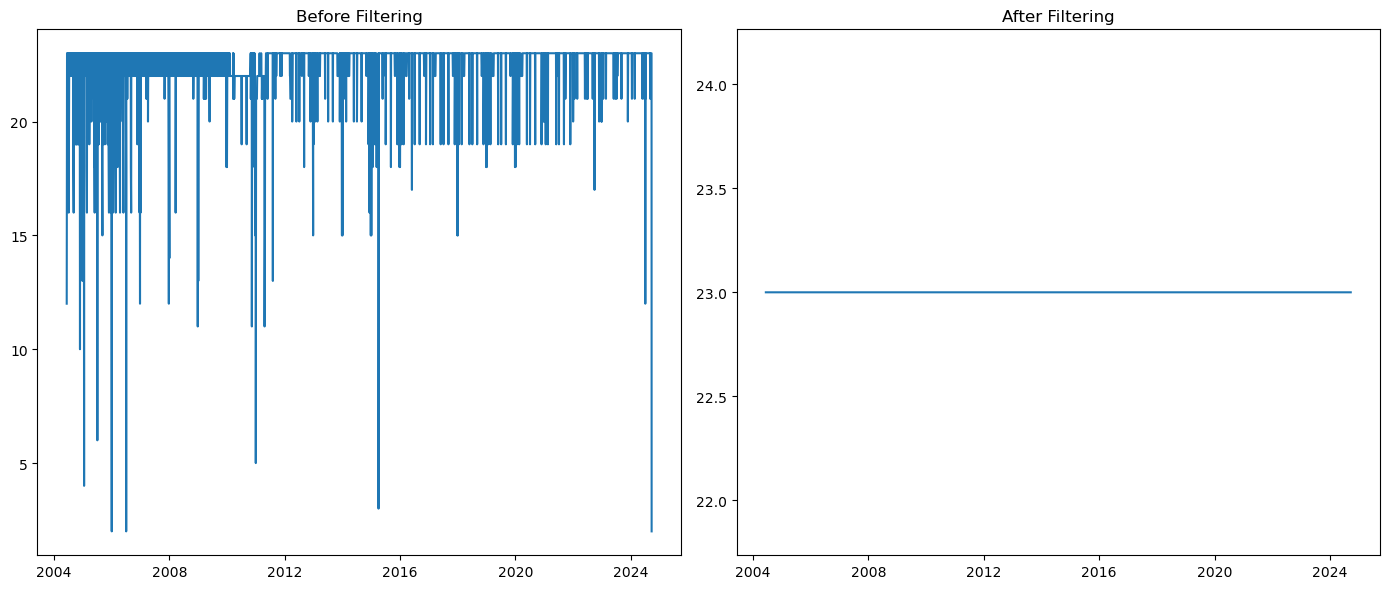

In [146]:
#data comparision of before and after filteriing 
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
gold_data_1h.groupby(gold_data_1h.index.date).size().plot(title='Before Filtering')
plt.subplot(1, 2, 2)
filtered_data.groupby(filtered_data.index.date).size().plot(title='After Filtering')
plt.tight_layout()
plt.show()

In [147]:
#normalising the data 

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features_to_scale = ['Open', 'High', 'Low', 'Close', 'Volume']
filtered_data[features_to_scale] = scaler.fit_transform(filtered_data[features_to_scale])


/var/folders/bz/q_7jbqjx7hj_vffhkj3cyl_m0000gn/T/ipykernel_11060/859946670.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[features_to_scale] = scaler.fit_transform(filtered_data[features_to_scale])


In [148]:
print(filtered_data[features_to_scale].describe())


               Open          High           Low         Close        Volume
count  97819.000000  97819.000000  97819.000000  97819.000000  97819.000000
mean       0.436804      0.435821      0.436785      0.436678      0.022161
std        0.213668      0.213191      0.213767      0.213724      0.025929
min        0.000000      0.000000      0.000000      0.000000      0.000000
25%        0.322386      0.321643      0.322391      0.322225      0.005481
50%        0.419190      0.418084      0.419342      0.419070      0.015988
75%        0.612027      0.610582      0.612007      0.611948      0.029705
max        1.000000      1.000000      1.000000      1.000000      1.000000


<Figure size 1000x500 with 0 Axes>

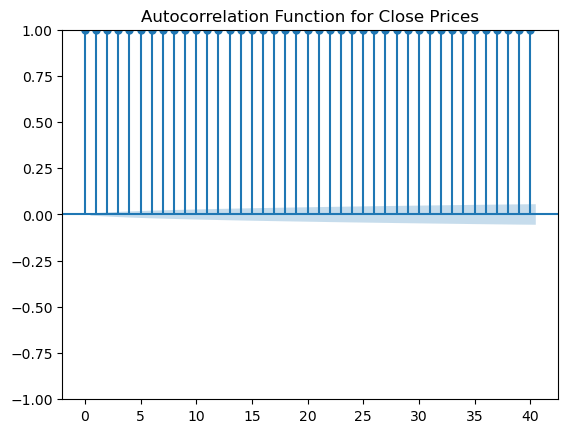

In [150]:
#autocorrelation analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(10, 5))
plot_acf(filtered_data['Close'], lags=40, alpha=0.05)  
plt.title('Autocorrelation Function for Close Prices')
plt.show()

In [149]:
#baseline model xg-boost 
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb




In [162]:
df_1 = filtered_data.copy()  #using it for xgboost , so retaining my original data after filtering 

In [163]:

selected_lags = [1, 3, 10, 20]
for lag in selected_lags:
    df_1[f'Close_lag_{lag}'] = df_1['Close'].shift(lag)

# Calculating rolling statistics based on 23 hour periods
df_1['rolling_mean_close'] = df_1['Close'].rolling(window=23).mean()
df_1['rolling_std_close'] = df_1['Close'].rolling(window=23).std()
df_1.dropna(inplace=True)


In [244]:
df_1.head()

,Open,High,Low,Close,Volume,Hour,Date,Close_lag_1,Close_lag_3,Close_lag_10,Close_lag_20,rolling_mean_close,rolling_std_close
DateTime,,,,,,,,,,,,,
2004-06-14 23:00:00,0.000679,0.000496,0.000680,0.000452,0.000115,23,2004-06-14,0.000362,0.000452,0.000588,0.000362,0.000541,0.000281
2004-06-15 01:00:00,0.000679,0.000586,0.000680,0.000452,0.000060,1,2004-06-15,0.000452,0.000452,0.001131,0.000543,0.000525,0.000275
2004-06-15 02:00:00,0.000905,0.000721,0.000544,0.000679,0.000357,2,2004-06-15,0.000452,0.000362,0.001267,0.000543,0.000531,0.000277
2004-06-15 03:00:00,0.000905,0.000812,0.000634,0.000317,0.000278,3,2004-06-15,0.000679,0.000452,0.001041,0.000452,0.000529,0.000278
2004-06-15 04:00:00,0.000452,0.000361,0.000453,0.000362,0.000199,4,2004-06-15,0.000317,0.000452,0.000452,0.000362,0.000521,0.000281


In [243]:
len(df_1)

97797

In [245]:
df_1['Hour'] = df_1['Hour'].astype(int)  #encoding hour 


In [246]:
df_1.head()

,Open,High,Low,Close,Volume,Hour,Date,Close_lag_1,Close_lag_3,Close_lag_10,Close_lag_20,rolling_mean_close,rolling_std_close
DateTime,,,,,,,,,,,,,
2004-06-14 23:00:00,0.000679,0.000496,0.000680,0.000452,0.000115,23,2004-06-14,0.000362,0.000452,0.000588,0.000362,0.000541,0.000281
2004-06-15 01:00:00,0.000679,0.000586,0.000680,0.000452,0.000060,1,2004-06-15,0.000452,0.000452,0.001131,0.000543,0.000525,0.000275
2004-06-15 02:00:00,0.000905,0.000721,0.000544,0.000679,0.000357,2,2004-06-15,0.000452,0.000362,0.001267,0.000543,0.000531,0.000277
2004-06-15 03:00:00,0.000905,0.000812,0.000634,0.000317,0.000278,3,2004-06-15,0.000679,0.000452,0.001041,0.000452,0.000529,0.000278
2004-06-15 04:00:00,0.000452,0.000361,0.000453,0.000362,0.000199,4,2004-06-15,0.000317,0.000452,0.000452,0.000362,0.000521,0.000281


In [247]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error ,r2_score ,mean_absolute_error

import numpy as np

X = df_1.drop(columns=['Close','Date'])
y = df_1['Close']

#using timeseries split to main chorology and also cross validates with splits 
tscv = TimeSeriesSplit(n_splits=5)
fold_results = []

#udf for calculating symmetric mape which is more robust for small values (scaled) , Also used in financial data due to near zero / anomolies 
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
fold_indices =[]

for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    fold_indices.append((train_index, test_index))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    model = xgb.XGBRegressor(objective='reg:squarederror')
    model.fit(X_train, y_train)
    
    # RMSE
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Fold {fold + 1} RMSE: {rmse:.4f}")
   
    # R-Squared
    r2 = r2_score(y_test, y_pred)
    print(f"Fold {fold + 1} R-Squared: {r2:.4f}")
    
    #MAE
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Fold {fold + 1} Mean Absolute Error: {mae:.4f}")

    #sMAPE
    smape_value = smape(y_test.values, y_pred)
    print(f"Fold {fold + 1}  sMAPE: {smape_value:.2f}%")

    
    # Store the fold's results
    fold_results.append(pd.DataFrame({
        'Fold': fold + 1,
        'Actual': y_test.values,
        'Predicted': y_pred,
        'Index': y_test.index
    }))


Fold 1 RMSE: 0.2049
Fold 1 R-Squared: -0.5475
Fold 1 Mean Absolute Error: 0.1482
Fold 1  sMAPE: 35.28%
Fold 2 RMSE: 0.0155
Fold 2 R-Squared: 0.9631
Fold 2 Mean Absolute Error: 0.0099
Fold 2  sMAPE: 2.44%
Fold 3 RMSE: 0.0008
Fold 3 R-Squared: 0.9994
Fold 3 Mean Absolute Error: 0.0006
Fold 3  sMAPE: 0.15%
Fold 4 RMSE: 0.0153
Fold 4 R-Squared: 0.9775
Fold 4 Mean Absolute Error: 0.0067
Fold 4  sMAPE: 1.03%
Fold 5 RMSE: 0.0749
Fold 5 R-Squared: 0.4300
Fold 5 Mean Absolute Error: 0.0348
Fold 5  sMAPE: 4.29%


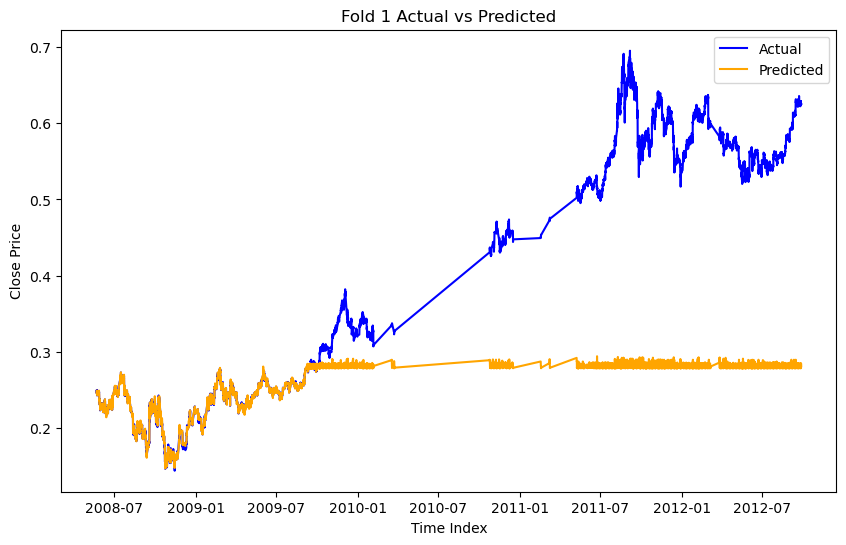

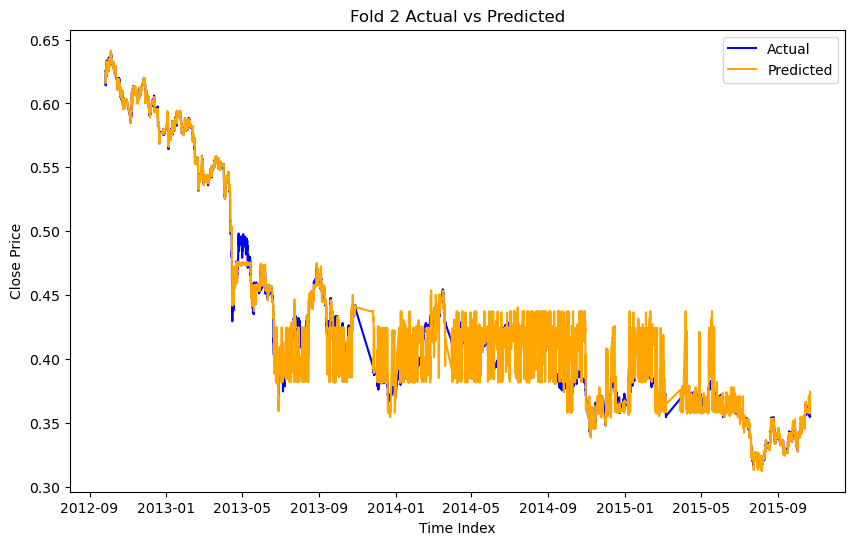

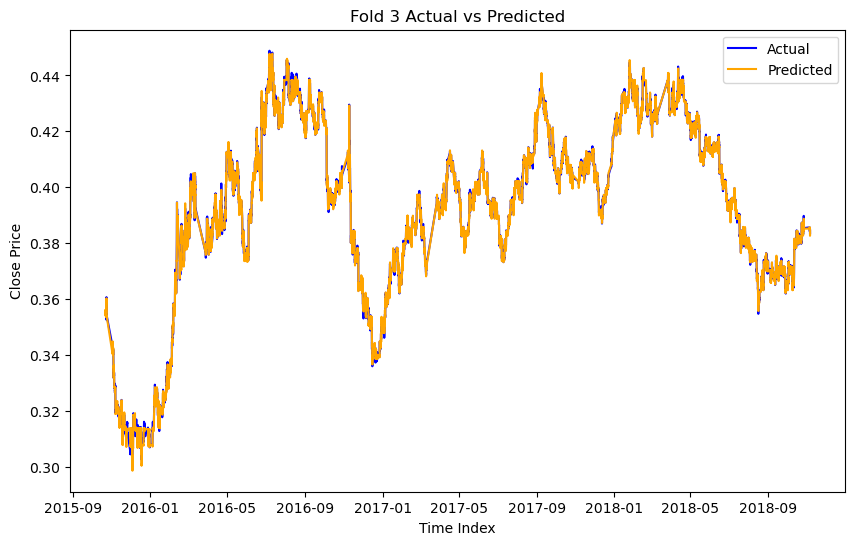

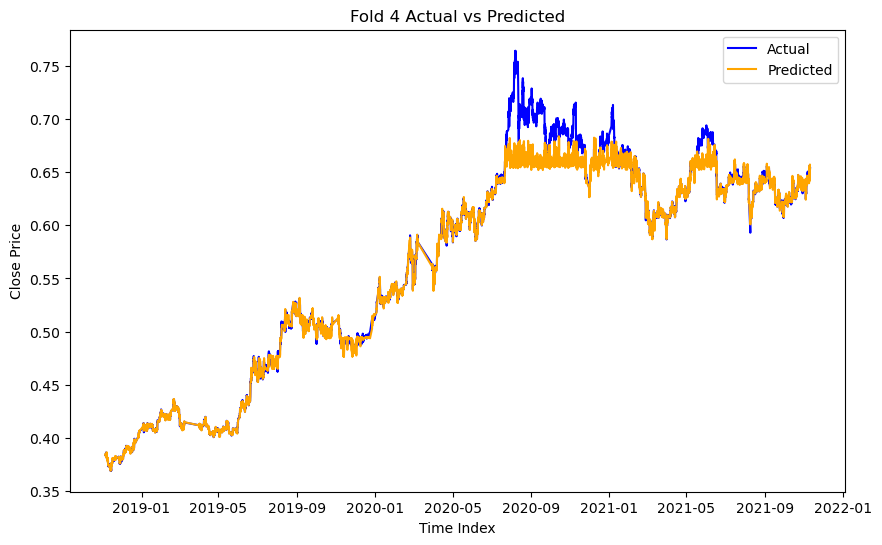

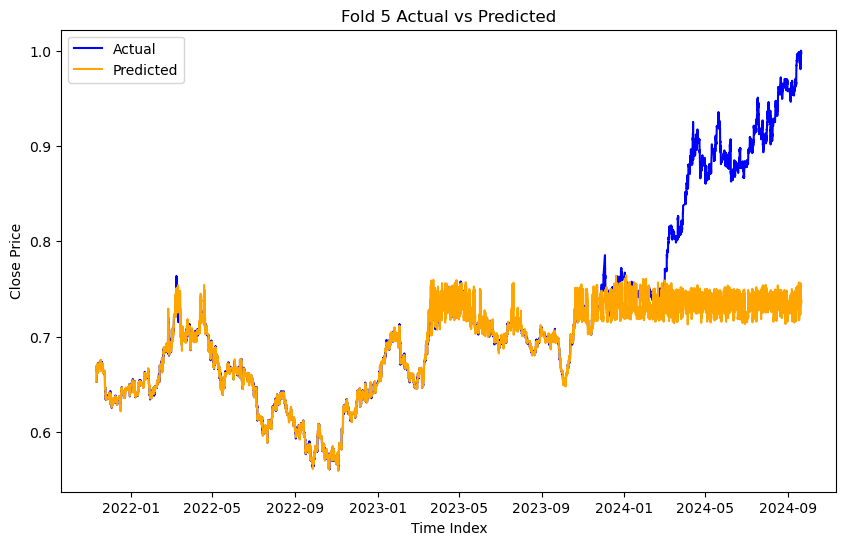

In [248]:
#comparing fold results with the actual to analyse if some saw more error due to volatality 
fold_results_df = pd.concat(fold_results, ignore_index=True)
for fold in fold_results_df['Fold'].unique():
    fold_data = fold_results_df[fold_results_df['Fold'] == fold]
    plt.figure(figsize=(10, 6))
    plt.plot(fold_data['Index'], fold_data['Actual'], label='Actual', color='blue')
    plt.plot(fold_data['Index'], fold_data['Predicted'], label='Predicted', color='orange')
    plt.title(f'Fold {fold} Actual vs Predicted')
    plt.xlabel('Time Index')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

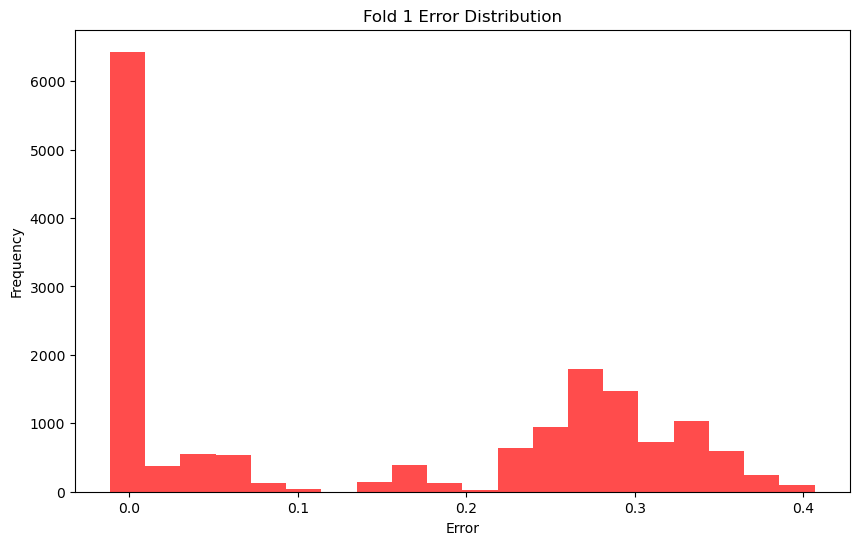

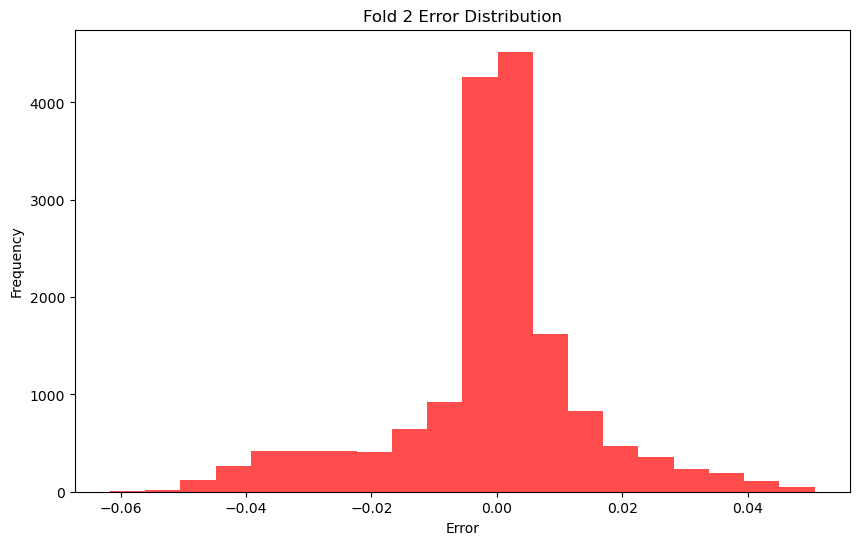

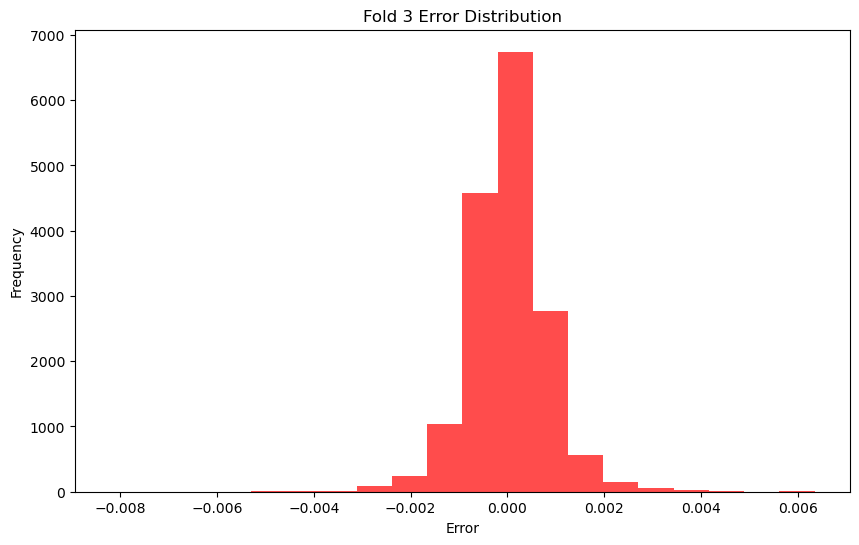

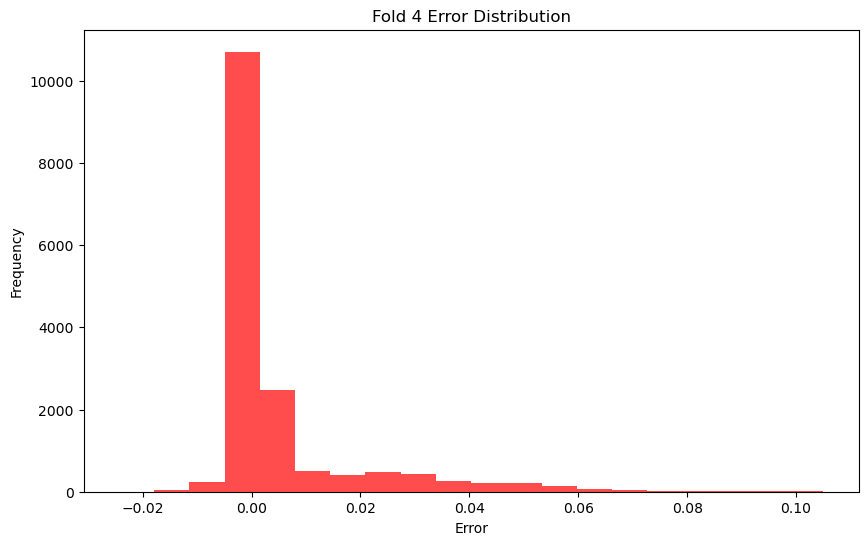

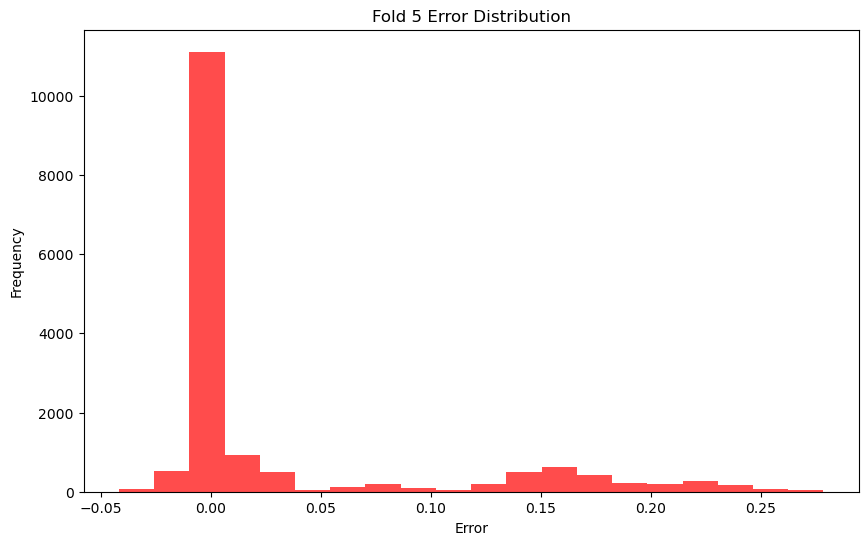

In [249]:
#prediction error check

fold_results_df['Error'] = fold_results_df['Actual'] - fold_results_df['Predicted']

for fold in fold_results_df['Fold'].unique():
    fold_data = fold_results_df[fold_results_df['Fold'] == fold]
    plt.figure(figsize=(10, 6))
    plt.hist(fold_data['Error'], bins=20, color='red', alpha=0.7)
    plt.title(f'Fold {fold} Error Distribution')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.show()


In [250]:
#fold specific data distribution 

for fold in fold_results_df['Fold'].unique():
    fold_data = fold_results_df[fold_results_df['Fold'] == fold]
    print(f"Fold {fold} Statistics:")
    print(fold_data.describe())


Fold 1 Statistics:
          Fold        Actual     Predicted                          Index  \
count  16299.0  16299.000000  16299.000000                          16299   
mean       1.0      0.409457      0.261868  2010-08-12 22:22:54.268359936   
min        1.0      0.144118      0.147078            2008-05-21 18:00:00   
25%        1.0      0.246320      0.246339            2009-04-02 21:30:00   
50%        1.0      0.433364      0.279078            2010-11-01 02:00:00   
75%        1.0      0.564668      0.281824            2011-12-21 05:30:00   
max        1.0      0.694994      0.294276            2012-09-26 09:00:00   
std        0.0      0.164711      0.031639                            NaN   

              Error  
count  16299.000000  
mean       0.147589  
min       -0.011406  
25%        0.000241  
50%        0.152128  
75%        0.282720  
max        0.406720  
std        0.142128  
Fold 2 Statistics:
          Fold        Actual     Predicted                          In

/var/folders/bz/q_7jbqjx7hj_vffhkj3cyl_m0000gn/T/ipykernel_11060/1415721011.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_data['Rolling Mean'] = fold_data['Actual'].rolling(window=5).mean()


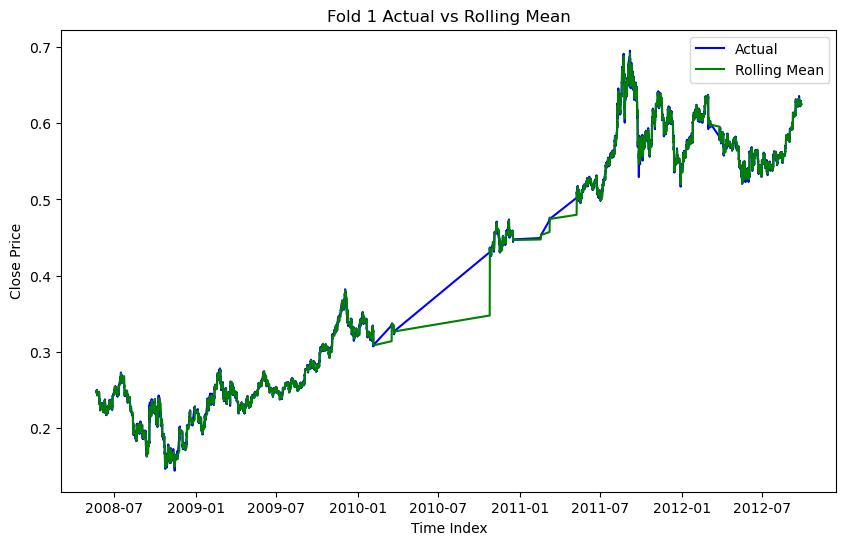

/var/folders/bz/q_7jbqjx7hj_vffhkj3cyl_m0000gn/T/ipykernel_11060/1415721011.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_data['Rolling Mean'] = fold_data['Actual'].rolling(window=5).mean()


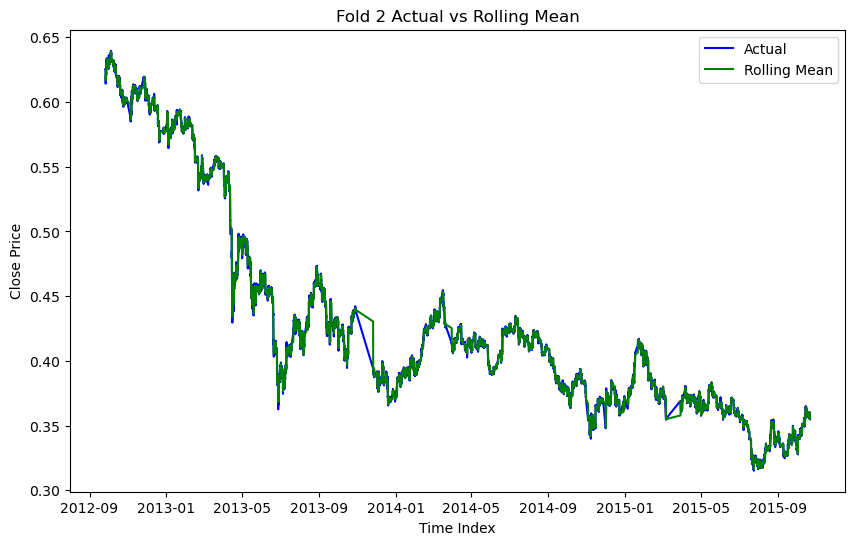

/var/folders/bz/q_7jbqjx7hj_vffhkj3cyl_m0000gn/T/ipykernel_11060/1415721011.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_data['Rolling Mean'] = fold_data['Actual'].rolling(window=5).mean()


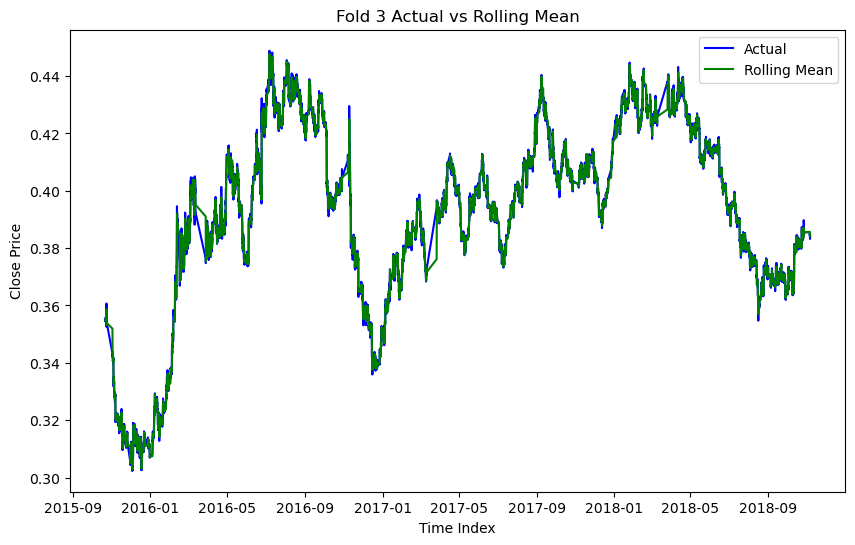

/var/folders/bz/q_7jbqjx7hj_vffhkj3cyl_m0000gn/T/ipykernel_11060/1415721011.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_data['Rolling Mean'] = fold_data['Actual'].rolling(window=5).mean()


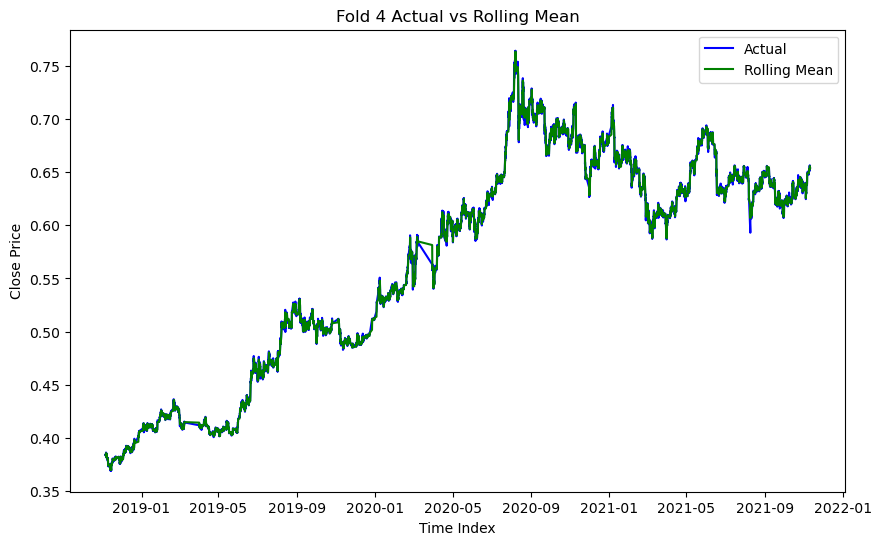

/var/folders/bz/q_7jbqjx7hj_vffhkj3cyl_m0000gn/T/ipykernel_11060/1415721011.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_data['Rolling Mean'] = fold_data['Actual'].rolling(window=5).mean()


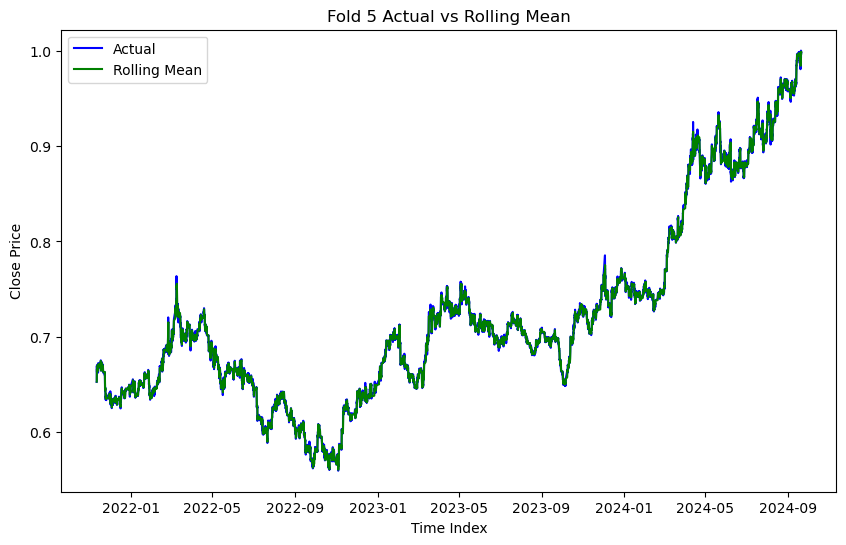

In [251]:
for fold in fold_results_df['Fold'].unique():
    fold_data = fold_results_df[fold_results_df['Fold'] == fold]
    fold_data['Rolling Mean'] = fold_data['Actual'].rolling(window=5).mean()
    plt.figure(figsize=(10, 6))
    plt.plot(fold_data['Index'], fold_data['Actual'], label='Actual', color='blue')
    plt.plot(fold_data['Index'], fold_data['Rolling Mean'], label='Rolling Mean', color='green')
    plt.title(f'Fold {fold} Actual vs Rolling Mean')
    plt.xlabel('Time Index')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()


Understanding from the experiment is that :
1. The period from 2008 to 2012 includes the global financial crisis, which likely caused unusual volatility and structural changes in market behavior, making it harder to predict.
2. Rolling  mean vs actual suugests the volatality that the model failed to understand 
3. Confirmed From all the metrics we confirm  that fold one is underperforming signaling anomalies, non-stationarity, or distribution shifts.


Next move reasons :
1. Dataset has long-term dependencies / non-linear relationships that XGBoost struggles to capture (e.g., the 2008–2012 period anomalies), deep learning models like LSTMs or GRUs are better suited for such tasks.
2. Deep learning models are more suited to learn such patterns without the need of feature engineering .
3.  Since our dataset is huge , its more helpful for deep learning models .

In [252]:
df_2.head()

,Open,High,Low,Close,Volume
DateTime,,,,,
2004-06-14 01:00:00,0.001357,0.001127,0.001133,0.000814,0.000066
2004-06-14 02:00:00,0.001357,0.001037,0.000544,0.000543,0.000357
2004-06-14 03:00:00,0.000679,0.000586,0.000544,0.000362,0.000308
2004-06-14 04:00:00,0.000588,0.000586,0.000680,0.000543,0.000272
2004-06-14 05:00:00,0.000679,0.000586,0.000770,0.000543,0.000097


In [253]:
df_2[:-1]

,Open,High,Low,Close,Volume
DateTime,,,,,
2004-06-14 01:00:00,0.001357,0.001127,0.001133,0.000814,0.000066
2004-06-14 02:00:00,0.001357,0.001037,0.000544,0.000543,0.000357
2004-06-14 03:00:00,0.000679,0.000586,0.000544,0.000362,0.000308
2004-06-14 04:00:00,0.000588,0.000586,0.000680,0.000543,0.000272
2004-06-14 05:00:00,0.000679,0.000586,0.000770,0.000543,0.000097
...,...,...,...,...,...
2024-09-19 18:00:00,0.995214,0.995203,0.996597,0.998760,0.242595
2024-09-19 19:00:00,0.998760,0.996605,0.999896,0.999941,0.167619
2024-09-19 20:00:00,0.999932,0.996659,1.000000,0.999425,0.108959


In [255]:
#LSTM implementation 
df_2 = filtered_data.copy()
df_2 = df_2.drop(columns=['Hour','Date'])
look_back = 23  # Using the past 23 hours to predict 

data = df_2[['Open', 'High', 'Low', 'Close', 'Volume']].values


# to create sequence 
def create_sequences(data, look_back):
    X, y = [], []
    for i in range(look_back, len(data)):
        # Slice the rows for the look-back period
        window = data[i-look_back:i, :]  # Select all columns initially
        # Select specific columns for features: Open, High, Low, Volume (indices 0, 1, 2, 4)
        X.append(window[:, [0, 1, 2, 4]])  
        # Select the Close column (index 3) as the target variable
        y.append(data[i, 3])  # Close
    return np.array(X), np.array(y)

In [256]:
X, y = create_sequences(data, look_back=look_back)

In [258]:
# X.shape
y.shape

(97796,)

In [260]:
original_indices = df_1.index #storing indices so that i can use even after converting series to numpy array 
original_indices

DatetimeIndex(['2004-06-14 23:00:00', '2004-06-15 01:00:00',
               '2004-06-15 02:00:00', '2004-06-15 03:00:00',
               '2004-06-15 04:00:00', '2004-06-15 05:00:00',
               '2004-06-15 06:00:00', '2004-06-15 07:00:00',
               '2004-06-15 08:00:00', '2004-06-15 09:00:00',
               ...
               '2024-09-19 14:00:00', '2024-09-19 15:00:00',
               '2024-09-19 16:00:00', '2024-09-19 17:00:00',
               '2024-09-19 18:00:00', '2024-09-19 19:00:00',
               '2024-09-19 20:00:00', '2024-09-19 21:00:00',
               '2024-09-19 22:00:00', '2024-09-19 23:00:00'],
              dtype='datetime64[ns]', name='DateTime', length=97797, freq=None)

In [262]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd

fold_results = []

for fold, (train_index, test_index) in enumerate(fold_indices):  # Using the same splits as XGBoost
    test_index = test_index[test_index < len(X)]

    # Reshape input for LSTM
    X_train = X[train_index].reshape(-1, 23, 4)  
    X_test = X[test_index].reshape(-1, 23, 4)
    y_train = y[train_index].flatten()  
    y_test = y[test_index].flatten()
    
    # LSTM Model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(23, 4)))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
 
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    
    # Evaluate
    y_pred = model.predict(X_test).flatten()  
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    smape_value = smape(y_test, y_pred)
    
    print(f"Fold {fold + 1} Metrics:")
    print(f" - RMSE: {rmse:.4f}")
    print(f" - R-Squared: {r2:.4f}")
    print(f" - Mean Absolute Error: {mae:.4f}")
    print(f" - sMAPE: {smape_value:.2f}%")

    fold_results.append(pd.DataFrame({
        'Fold': fold + 1,
        'Actual': y_test,
        'Predicted': y_pred,
        'Index': original_indices[test_index]
    }))


/Users/abhisheksuga/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


510/510 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Fold 1 Metrics:
 - RMSE: 0.0053
 - R-Squared: 0.9990
 - Mean Absolute Error: 0.0038
 - sMAPE: 0.97%


/Users/abhisheksuga/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


510/510 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
Fold 2 Metrics:
 - RMSE: 0.0049
 - R-Squared: 0.9963
 - Mean Absolute Error: 0.0034
 - sMAPE: 0.72%


/Users/abhisheksuga/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


510/510 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
Fold 3 Metrics:
 - RMSE: 0.0052
 - R-Squared: 0.9736
 - Mean Absolute Error: 0.0047
 - sMAPE: 1.20%


/Users/abhisheksuga/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


510/510 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Fold 4 Metrics:
 - RMSE: 0.0133
 - R-Squared: 0.9832
 - Mean Absolute Error: 0.0125
 - sMAPE: 2.14%


IndexError: index 97796 is out of bounds for axis 0 with size 97796

In [263]:
for fold, (train_index, test_index) in enumerate(fold_indices):
    print(f"Fold {fold + 1}:")
    print(f"Train Index Max: {max(train_index)}, Train Index Min: {min(train_index)}")
    print(f"Test Index Max: {max(test_index)}, Test Index Min: {min(test_index)}")


Fold 1:
Train Index Max: 16301, Train Index Min: 0
Test Index Max: 32600, Test Index Min: 16302
Fold 2:
Train Index Max: 32600, Train Index Min: 0
Test Index Max: 48899, Test Index Min: 32601
Fold 3:
Train Index Max: 48899, Train Index Min: 0
Test Index Max: 65198, Test Index Min: 48900
Fold 4:
Train Index Max: 65198, Train Index Min: 0
Test Index Max: 81497, Test Index Min: 65199
Fold 5:
Train Index Max: 81497, Train Index Min: 0
Test Index Max: 97796, Test Index Min: 81498


In [264]:
print(f"X size: {len(X)}, y size: {len(y)}")


X size: 97796, y size: 97796


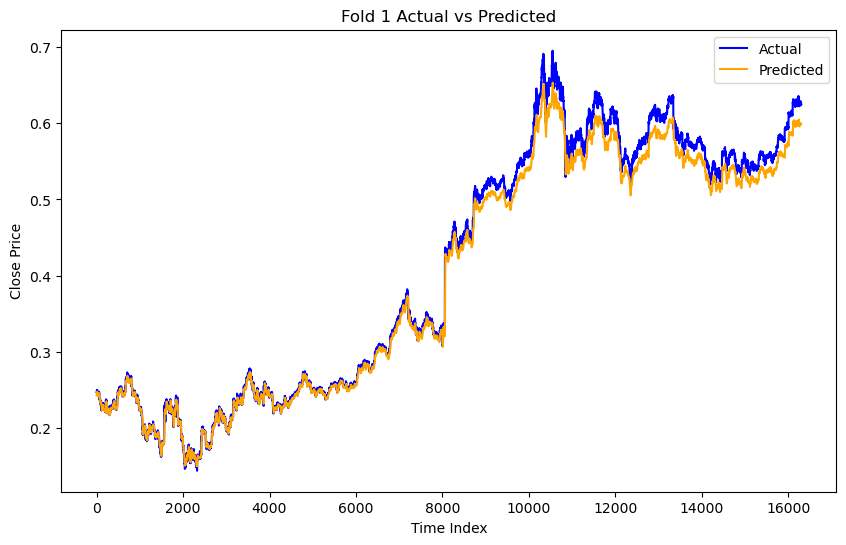

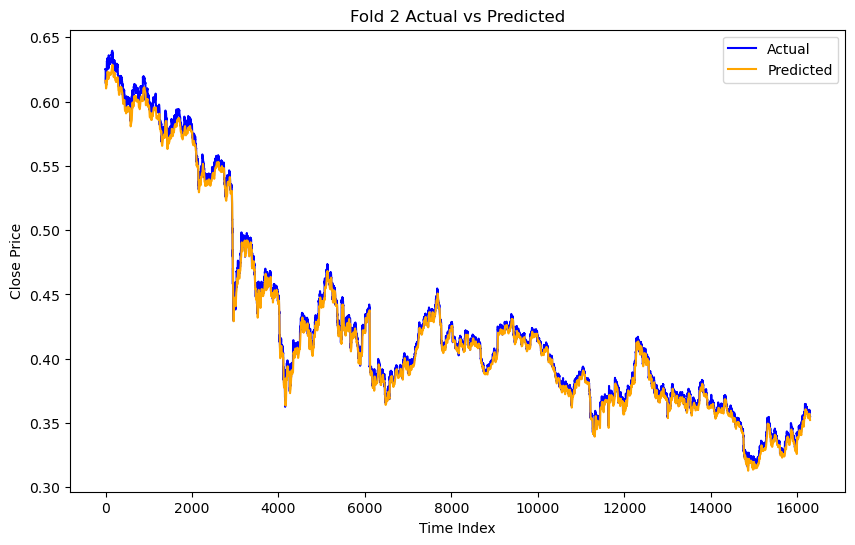

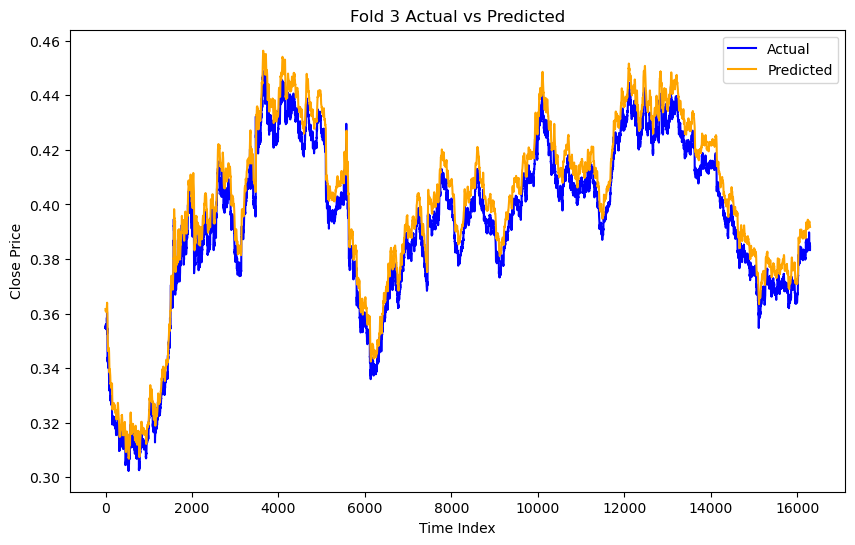

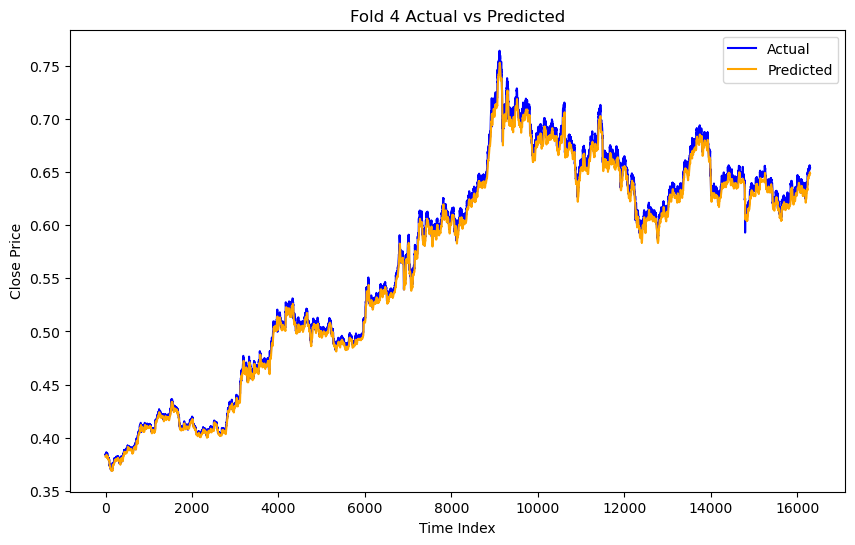

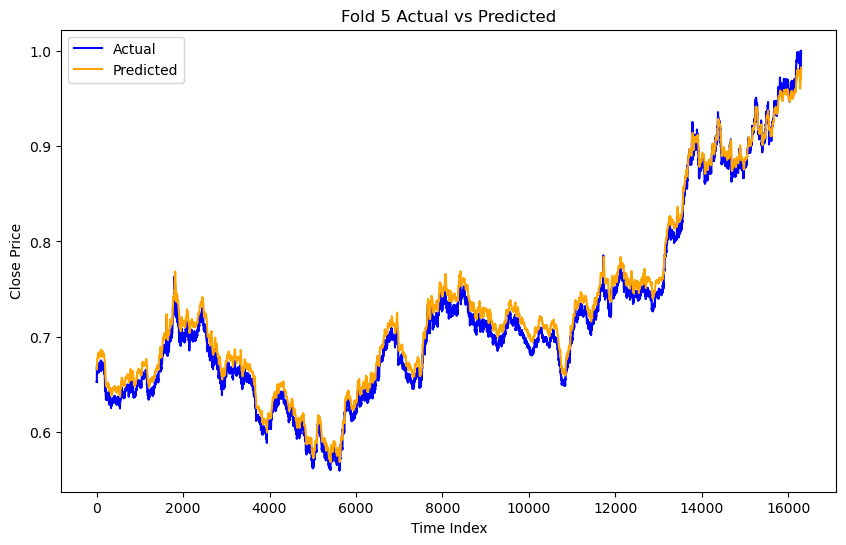

In [237]:
fold_results_df1 = pd.concat(fold_results, ignore_index=True)

for fold in fold_results_df1['Fold'].unique():  # Fixed from fold_results['Fold']
    fold_data = fold_results_df1[fold_results_df1['Fold'] == fold]
    plt.figure(figsize=(10, 6))
    plt.plot(fold_data['Index'], fold_data['Actual'], label='Actual', color='blue')  # Ensure Index is valid
    plt.plot(fold_data['Index'], fold_data['Predicted'], label='Predicted', color='orange')
    plt.title(f'Fold {fold} Actual vs Predicted')
    plt.xlabel('Time Index')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()


In [240]:
fold_results_df.head()

,Fold,Actual,Predicted,Index,Error
0,1,0.247105,0.246143,2008-05-21 18:00:00,0.000962
1,1,0.247422,0.246835,2008-05-21 19:00:00,0.000586
2,1,0.248327,0.247057,2008-05-21 20:00:00,0.001270
3,1,0.248463,0.249166,2008-05-21 21:00:00,-0.000704
4,1,0.249096,0.249124,2008-05-21 22:00:00,-0.000028


In [242]:
y_test

array([0.65268169, 0.65328802, 0.65311608, ..., 0.99835293, 0.99843438,
       0.99743438])